## Tarun Nadipalli - 705.603 Creating AI-Enabled Systems Final Project

For my final project, I decided to build my own content-based song recommendation application with the Spotify API. Users are able to input a link to a Spotify playlist that contains songs they like and my application will send back a link to playlist that contains my recommended songs. 

This guide is a continuation from the `data_collection.ipynb` notebook that describes my data collection methods. In this notebook, we will define the different data we have collected, conduct a smaller analysis of the data, discuss some of the data design decisions, and some general thoughts about how the data may affect the results of my recommendation system.

Note that for my final dataset, I only gathered 300,000 songs of the potential 2 million unique songs in Spotify's Million Playlist Dataset. This is due to the constraints of my laptop's processing power.

In [1]:
from data import *

db_file = './data/spotify_data.db'

conn = create_connection(db_file)
songs = get_table_df(conn, 'features', '300000')

songs.head()

INFO:root:Connection to ./data/spotify_data.db is successful!
INFO:root:Reading table features from database.


,track_id,track_uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,1,00z4wF0iJsp6GwDkQxkGs6,0.737,0.818,8.0,-2.892,1.0,0.0492,0.09360,0.000000,0.0577,0.893,116.930,232859,4
1,2,00cSN1TMyHZErfyJbLMB05,0.814,0.481,7.0,-7.892,1.0,0.0295,0.34500,0.410000,0.0693,0.834,110.002,208813,4
2,3,01A7PEPSnmtixFPfB2UTal,0.793,0.631,11.0,-6.109,0.0,0.0998,0.04060,0.000478,0.2070,0.231,119.971,226693,4
3,4,00BuKLSAFkaEkaVAgIMbeA,0.825,0.832,5.0,-5.853,0.0,0.0403,0.00587,0.000789,0.1140,0.713,122.021,220627,4
4,5,00rrluZUPNbfTSWvodUZbV,0.513,0.546,5.0,-5.703,1.0,0.0282,0.01810,0.000000,0.1220,0.245,141.876,246560,4


Now that we have our 300,000 songs and their features, let's define the different features that Spotify provides us with for each song.

**Audio Features**

- ***Track ID***: The index of the song within the table
  
- ***Track URI***: The unique URI or identifier for the song
- ***Danceability***: Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- ***Energy***: Measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- ***Key***: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
- ***Loudness***: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
- ***Mode***: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- ***Speechiness***: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- ***Acousticness***: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- ***Instrumentalness***: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- ***Liveness***: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
- ***Valence***: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- ***Tempo***: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
- ***Duration (ms)***: The duration of the track in milliseconds.
- ***Time Signature***: An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".

These definitions were gathered from Spotify's Web API Guide [here](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features).

#### Design Decisions

After reading through those features, you might be wondering why there is no column for 'genre', 'artist name' or 'song name'. There is one main reason why I decided not to collect those features for the songs. 

My reasoning is that in my personal experience using Spotify, I constantly find myself being recommended songs within the same genre with similar artists. A part of my motivation in creating this recommendation system is to find good songs to recommend based solely on the characteristics of the song. This is in an effort to allow users to discover songs or artists they might not have even thought to listen to before, but can be assured that these songs are not that different from what they usually listen to. 

I made this decision due to my research on recommender systems in my research paper, which led me to understand how big of a problem echo chambers and feedback loops are within these systems. In order to break out of that system, I am introducing noise into my system by not including those three features.

#### Limitations / Concerns

1. *Spotify Million Playlist Dataset only contains pre-2018 songs*
    
    Since the Spotify MPD only contains user-created playlists from 2010-2017, we do not have songs that have come out in the last 5 years. This is a problem for a couple reasons. First off, all of our possible recommendations will be older songs which increases the chance that the user has already listened to them. In addition, music as an industry changes quite a lot. If we consider how pop songs sound now (much more rap or hip-hop) versus the early 2000's pop, there is a large difference in the characteristics of these songs. If a user sends me a playlist of their liked songs from the last few years, there may not be many similar or "great" recommendations to provide for them. 

2. *Our recommendations are based on how Spotify determines a song's features*

    Since our song recommendation system is built off of the characteristics that Spotify determines, there is definitely some skew that will be present in our results. In any recommender system, there will be this type of bias, but since we are only going off of what Spotify provides us we are at the mercy of how well they define features like danceability or valence. In fact, we have small descriptions of these metrics, but have no idea as to how these characteristics are quantified. 

3. *Popularity Bias in this dataset*

    Since this dataset is directly from user-created playlists, there is definitely some level of popularity bias in the dataset. This is due to the fact that we are not recommending ANY song from Spotify's entire library, but are actually recommending songs that were good enough for someone to think that it belonged in a playlist. One on hand this is good because it filters out songs that no one wants to listen to, but on the other hand it definitely adds some additional bias into the dataset.

#### Exploratory Analysis

Now, let's move on and conduct a simple exploratory analysis of the data. This isn't really important for creating the recommendation itself since we can't control nor quantify the amount of bias in the dataset from the concerns listed in the section above. We care more that the data is clean and standardized (it is, thanks to Spotify!).

That being said, I am curious on what the dataset generally looks like from a statistical standpoint. Let's take a look.

In [2]:
songs.describe()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,3.000000e+05,300000.000000
mean,149933.937597,0.564251,0.615112,5.252780,-8.492128,0.659327,0.087887,0.300240,0.145891,0.203589,0.470381,120.830245,2.406677e+05,3.905213
std,86564.293849,0.175339,0.247314,3.571631,4.819391,0.473936,0.102607,0.326266,0.295781,0.180099,0.256801,29.509886,1.100566e+05,0.416417
min,1.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+03,0.000000
25%,75000.750000,0.450000,0.447000,2.000000,-10.318000,0.000000,0.034800,0.019200,0.000000,0.096200,0.259000,97.923000,1.915180e+05,4.000000
50%,149900.500000,0.576000,0.654000,5.000000,-7.269000,1.000000,0.047100,0.152000,0.000068,0.127000,0.457000,120.050000,2.256530e+05,4.000000
75%,224900.250000,0.693000,0.819000,8.000000,-5.305000,1.000000,0.088100,0.550000,0.046800,0.257000,0.674000,139.851000,2.693870e+05,4.000000
max,299901.000000,0.991000,1.000000,11.000000,3.744000,1.000000,0.965000,0.996000,1.000000,1.000000,1.000000,247.938000,5.279768e+06,5.000000


From the description of all of the features, I can tell a few different things.

The first is that this is not a dataset that has a lot of instrumental songs, since the mean for 'instrumentalness' is so low at 0.146.
In addition, there is not much poetry, spoken word or podcast-like songs as indicated by the low mean value for 'speechiness'. 
The rest of the features seem pretty reasonable and average amongst all the songs, meaning that they don't skew to one side or another. This is good because it indicates to me that we have a good blend of music in our 300,000 songs!!


Now, let's make a correlation matrix for our data and see how the features interact with one another. Does loudness also indicate liveness? Are acousticness and speechiness more directly correlated? Let's find out.

<AxesSubplot: >

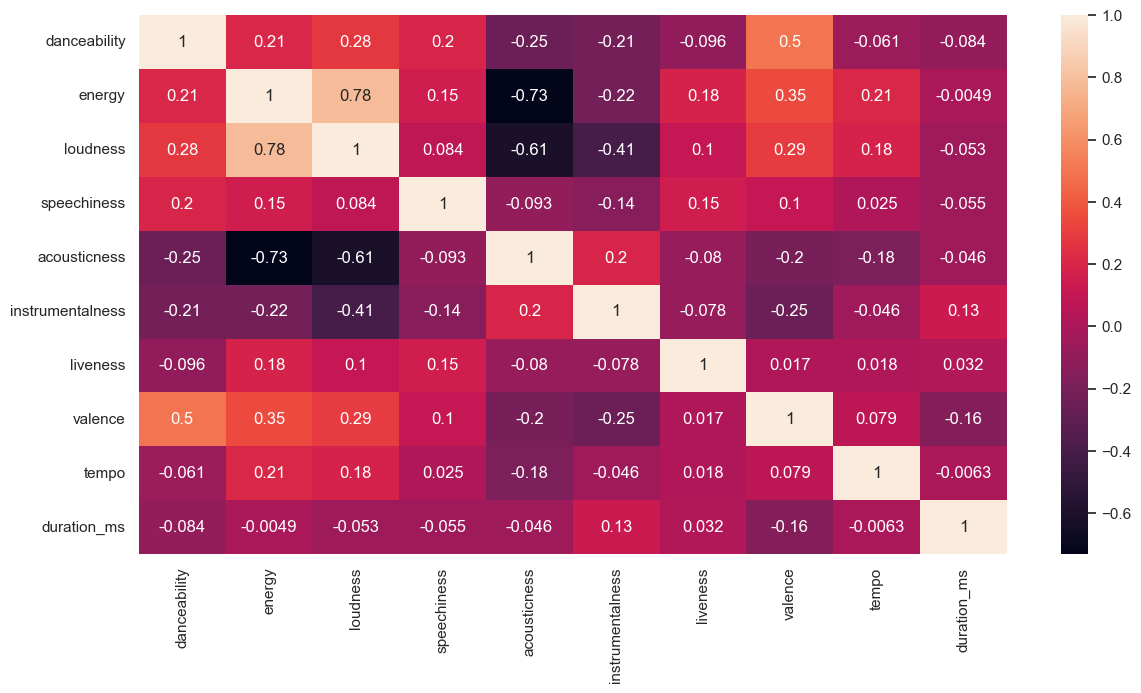

In [4]:
import seaborn as sns 
import matplotlib.pyplot as plt

columns_include=["danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms"]
corr_df = songs[columns_include]

corr = corr_df.corr()
plt.figure(figsize=(14,7))
sns.set(style="whitegrid")
sns.heatmap(corr,annot=True)

Loving this plot! Here's what I've gathered from looking at this correlation plot.

Loudness and Energy are highly correlated features! This makes sense as songs that are loud across an entire track are energetic and fun. In addition, both Loudness and Energy are very much inversely correlated with Acousticness and Instrumentalness. This makes sense since a Country song with a lot of acoustic guitars may not be considered loud or energetic in comparison to EDM or Heavy Metal songs. I also see a slight indication that Energy and Loudness correlate with Valence, which is interesting since Valence represents the positivity of a track.

With an understanding of the data and the reasons for making some data design decisions, let's move on to the recommendation algorithm.

#### References

1. [Spotify Feature Definitions](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features)